In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [2]:
start_token = " "

with open("train.txt") as f:
    lines = f.read()[:-1].split('\n')
    lines = [start_token + line for line in lines]

In [3]:
with open('train_ans.txt') as file:
    target = file.readlines()
    target = [float(num.strip()) for num in target]

target_tensor = torch.Tensor(target)

In [4]:
!ls

rnn.ipynb  test.txt  train.txt	train_ans.txt


In [5]:
print('n samples = ', len(lines))

print(lines[0])

n samples =  300
 spot qbnlosrslnq pnmqppqtpsrna smnrnao wnvnqpanvrsuulw  nososanmvplqrmqsosutantotvskwlbj ktqtrstqlroasvnoqsallqpsrskslsrnssornpurpqktabsroutlbnnuvmlqupnqlprqolsoqstlaltnuvrorrrwa lavmvqaprwlpo rbmtqkomaploampqvoawqpmnnarouua xtrabaurrpapmmswsrna nqqrpbjspmaltntnlmmujpooppoooortooqq lbtmnrkapootqjp sanrupararrntmukvsmqmjvpstl qrzruktppontlrouqlsnnp qriqospasmvnxrpqmskqqquqnurotomlaqlqmnratsrappllntnsmusprk vpmsnsaqtnaqpnvnpmnjqsxtpsanrkp krvuhospacoqpmvqaupnspmqotpqpraustrspaa pom qqnkatnrqulouuqqoaqpmaqvpqalmrxssnstopmranmmnrlpuonarspkbpqa qops qtqmjntwmabrc uxqnhooopajuwanrvurap srqq aamuunlmlotarrovpspqjqunorrptosnqfarruqqonsqquqro r opqorpqqlnpotstr mtqal loqqrpsrnrqpjsvooaou ylpokmrnoasaivbtownqorossllrpvupvjsnomnruqq mqlqokbuqrqqooopbkppmomptvrplkvobomoouqsnqroslmtawokkpsmmxtqporuokrpkjnmljsskqsoqqfqhrbkqqpumnnqnnnblnsalssoqsksl clspssprrqwsrmqxomavplo n nasbsonlplnsnnqpoooos tnsomjmvuuqqsarrtug noqspwrqrppmplwaooaspbtvplptark ro nqjbaqqpqnrpvl sotk sqrnnpr marpu

max length = 49622
min length = 48


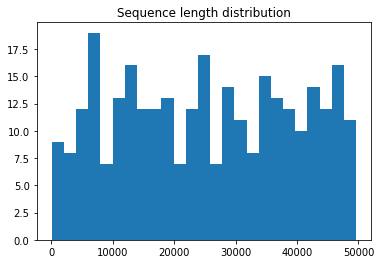

In [6]:
lens = list(map(len, lines))
MAX_LENGTH = max(lens)
MIN_LENGTH = min(lens)
print("max length =", MAX_LENGTH)
print("min length =", MIN_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

In [7]:
#all unique characters go here
tokens = set(np.concatenate([list(line) for line in lines]))

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  31


In [8]:
token_to_id = {tokens[i]:i for i in range(len(tokens))}

In [9]:
def to_matrix(lines, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return torch.tensor(lines_ix)

In [10]:
to_matrix(['fsdf fs', 'sfsdf'])

tensor([[16, 23,  1, 16, 22, 16, 23],
        [23, 16, 23,  1, 16, 22, 22]], dtype=torch.int32)

In [11]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
torch.cuda.set_device(1)

GPU is available


In [12]:
batch_size = 10

class RNN(nn.Module):
    def __init__(self, num_tokens, emb_size, hidden_dim, n_layers, output_size, device, bidir=True):
        super().__init__()
        
        self.bidir = bidir
        self.mult = 2 if bidir else 1
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_dim, n_layers,
                          batch_first=True, bidirectional=bidir)
        self.fc1 = nn.Linear(hidden_dim * self.mult, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_size)


    def forward(self, x):
        hidden = self.init_hidden(batch_size)
        x_emb = self.embedding(x)
        
        out, hidden = self.rnn(x_emb, hidden)
        
        if self.bidir:
            out = self.fc1(torch.cat((hidden[0], hidden[1]), dim=-1))
        else:
            out = self.fc1(hidden)
        out = self.fc2(out)

        return out.squeeze()


    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.mult, batch_size, self.hidden_dim).to(device)
        return hidden


model = RNN(num_tokens=num_tokens,
            emb_size=32,
            hidden_dim=128,
            n_layers=1,
            output_size=1,
            device=device)

model.to(device)

RNN(
  (embedding): Embedding(31, 32)
  (rnn): GRU(32, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
opt = torch.optim.Adam(model.parameters())

criterion = torch.nn.MSELoss()

In [14]:
def train_loop(n_epochs, lr):
    for g in opt.param_groups:
        g['lr'] = lr
    
    for i in range(n_epochs):
        j = 0
        losses = []
        while j + batch_size <= len(lines):
            opt.zero_grad()

            X_batch = to_matrix(lines[j: j + batch_size]).to(device)
            y_batch = target_tensor[j: j + batch_size].to(device)

            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()

            opt.step()

            j += batch_size

            losses += [loss.item()]

        print(f'Epoch {i + 1}:', 'mean loss =', np.mean(losses))

In [15]:
%%time

train_loop(50, 0.001)

208.19970801671346
145.21627356211346
139.15412508646648
133.9319662729899
129.14595295588177
122.514750734965
104.87870394388834
87.484157594045
63.37496732076009
60.08398329416911
45.11982622146606
33.035103972752886
26.95128698348999
28.27607644399007
21.830643423398335
17.76788838704427
14.761630900700887
16.67577969233195
14.291736952463786
10.03131312529246
9.899371727307637
11.206713716189066
16.126178606351218
10.782480883598328
8.486400707562764
5.757856460412343
5.060694511731466
4.7215350786844885
4.678534352779389
3.6690390507380166
3.379631527264913
4.898240681489309
3.960799241065979
4.044676923751831
3.187278288602829
4.207499861717224
4.102465442816416
5.315885106722514
4.287771612405777
5.63565243879954
5.7974771896998085
5.075432988007863
3.635056757926941
3.545534614721934
2.8537109663089115
2.3431279281775157
2.330397226413091
2.3900175511837007
2.2195704013109205
1.8063716381788253
CPU times: user 54min 5s, sys: 2min 31s, total: 56min 36s
Wall time: 55min 10s


### Calculate RMSE on train

In [16]:
j = 0
batch_size = 10
outputs = []

with torch.no_grad():
    while j + batch_size <= len(lines):
        X_batch = to_matrix(lines[j: j + batch_size]).to(device)
        outputs += [model(X_batch)]
        j += batch_size

predictions = torch.cat(outputs).cpu().numpy()

In [17]:
from sklearn.metrics import mean_squared_error


mean_squared_error(target_tensor.numpy(), predictions, squared=False)

1.3359711